# Project: European Soccer Match 
## Overview
 The ultimate Soccer database for data analysis. A thorough data collection and processing about soccer matches, containing teams' attributes from FIFA. Data is scattered across different websites.
## Database 
- Over 25000 matches & 10000 teams players' attributes for European Professional Football. 
- Data is weekly updated from seasons 2008 to 2016.
- The database is stored in a SQlite database. 
### Database.sqlite

| Table             | Total Columns     | Total Rows 
| ------------      | --------------    | -----------
| Country           |  11               |  2       
| League            |  11               |  3
| Match             |  25979            | 115
| Player            |  11060            |  7
| Player_Attributes |  183978           |  42
| Team              |  299              |  5 
| Team_Attributes   |  1458             |  25 

## Content
<ul>
<li><a href="#intro">Introduction</a></li>
<li><a href="#wrangling">Data Wrangling</a></li>
<li><a href="#eda">Exploratory Data Analysis</a></li>
<li><a href="#conclusions">Conclusions</a></li>
</ul>



<a id='intro'></a>
## Introduction

### Motivation

As SQL is becomming integral part in Data Analysis, especially when working with tabular data. Usually, data is not all stored in one table, but will be divided in multiple tables to be convenient for organizing information structurally. Hence, designing the data structure is very important, to reduce redundancy in data stored per table.
In this analysis, pd.read_sql will be used to extract data, to make relationship between tables to utilise the database file.

### Research question 
 1. Country Reference: Which country host the most matches by year? Which contry hold the most goals over year? 
 2. Player Reference: Which zodiac signs account the most among the players in Europe by season? Height and Weight distribution among players?
 3. Team reference: Is there significant difference in performance between home team and away team?

<a id='wrangling'></a>
## Data Wrangling


In [52]:
import numpy as np 
import pandas as pd
import sqlite3
import matplotlib.pyplot as plt 
import scipy 
from scipy import stats

In [53]:
path = r"C:\Users\trtu2001\Downloads\Investigate European Soccer Dataset\database.sqlite"

conn = sqlite3.connect(path)
tables = pd.read_sql("select * from sqlite_master where\
     type = 'table';", conn)
tables


,type,name,tbl_name,rootpage,sql
0,table,sqlite_sequence,sqlite_sequence,4,"CREATE TABLE sqlite_sequence(name,seq)"
1,table,Player_Attributes,Player_Attributes,11,"CREATE TABLE ""Player_Attributes"" (\n\t`id`\tIN..."
2,table,Player,Player,14,CREATE TABLE `Player` (\n\t`id`\tINTEGER PRIMA...
3,table,Match,Match,18,CREATE TABLE `Match` (\n\t`id`\tINTEGER PRIMAR...
4,table,League,League,24,CREATE TABLE `League` (\n\t`id`\tINTEGER PRIMA...
5,table,Country,Country,26,CREATE TABLE `Country` (\n\t`id`\tINTEGER PRIM...
6,table,Team,Team,29,"CREATE TABLE ""Team"" (\n\t`id`\tINTEGER PRIMARY..."
7,table,Team_Attributes,Team_Attributes,2,CREATE TABLE `Team_Attributes` (\n\t`id`\tINTE...


### Research question 1: Which country host the most matches over year? Which country hold the most goals over year? 

In [54]:

df = pd.read_sql("""
with t1 as (
select season, country_id, league_id, count(match_api_id) count_match
,rank () over (partition by season order by count(match_api_id) desc) max_match 
,rank () over (partition by season order by count(match_api_id)) min_match
,sum(count(match_api_id)) over (partition by season) total_match
from match
group by season, country_id, league_id)
select season Season, t2.name Country, t3.name League, 
case when max_match = 1 then count_match else null end
"max no. matches by season and country",
case when min_match = 1 then count_match else null end
"min no. matches by season and country"
, total_match "total match by season" from t1 
join Country t2
    on t1.country_id = t2.id
join League t3
     on t1.league_id = t3.id
where 1=1
and max_match = 1
or min_match = 1
;
 """, conn)
df


 
 

,Season,Country,League,max no. matches by season and country,min no. matches by season and country,total match by season
0,2008/2009,England,England Premier League,380.0,NaN,3326
1,2008/2009,France,France Ligue 1,380.0,NaN,3326
2,2008/2009,Italy,Italy Serie A,380.0,NaN,3326
3,2008/2009,Spain,Spain LIGA BBVA,380.0,NaN,3326
4,2008/2009,Switzerland,Switzerland Super League,NaN,180.0,3326
5,2009/2010,England,England Premier League,380.0,NaN,3230
6,2009/2010,France,France Ligue 1,380.0,NaN,3230
7,2009/2010,Italy,Italy Serie A,380.0,NaN,3230
8,2009/2010,Spain,Spain LIGA BBVA,380.0,NaN,3230
9,2009/2010,Switzerland,Switzerland Super League,NaN,180.0,3230


Over years, from season 2008 to 2016, England, France, Italy and Spain remained the top countries which hosted the most matches (380 matches), while Switzerland hosted the least matches in almost seasons. The least matches hosted by a country over time is 12 matches, which is Belgium in season 2013/2014, and this season is also the season with the least matches (3023 matches) in the dataset.

In [55]:
df = pd.read_sql("""
select season Season, c.name Country, l.name League
,round((sum(home_team_goal) + sum(away_team_goal))*1.0/count(match_api_id),3) "Goals per match"
,round(sum(home_team_goal)*1.0/count(match_api_id),3) "Home team goals per match"
,round(sum(away_team_goal)*1.0/count(match_api_id),3) "Away team goals per match"
,sum(home_team_goal) + sum(away_team_goal) "Total goals"
,count(match_api_id) "Total matches"
from match m
join Country c
    on m.country_id = c.id
join League l
    on m.league_id = l.id
group by season, c.name, l.name
order by season asc, "Goals per match" desc
;""", conn)
df

,Season,Country,League,Goals per match,Home team goals per match,Away team goals per match,Total goals,Total matches
0,2008/2009,Switzerland,Switzerland Super League,3.000,1.756,1.244,540,180
1,2008/2009,Germany,Germany 1. Bundesliga,2.922,1.699,1.222,894,306
2,2008/2009,Spain,Spain LIGA BBVA,2.897,1.661,1.237,1101,380
3,2008/2009,Netherlands,Netherlands Eredivisie,2.843,1.712,1.131,870,306
4,2008/2009,Belgium,Belgium Jupiler League,2.794,1.631,1.163,855,306
...,...,...,...,...,...,...,...,...
83,2015/2016,Portugal,Portugal Liga ZON Sagres,2.716,1.513,1.203,831,306
84,2015/2016,England,England Premier League,2.700,1.492,1.208,1026,380
85,2015/2016,Poland,Poland Ekstraklasa,2.646,1.421,1.225,635,240
86,2015/2016,Italy,Italy Serie A,2.576,1.471,1.105,979,380


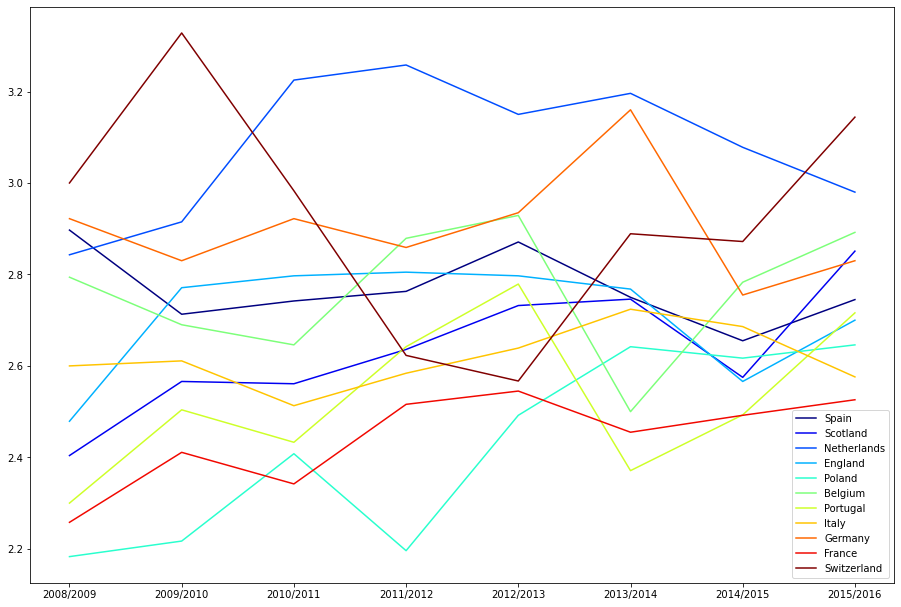

In [56]:
import matplotlib.pylab as pl
import matplotlib.pyplot as plt
ax1 = plt.axes([2,2,2,2])
labels = set(df['Country'].values)
colors = pl.cm.jet(np.linspace(0,1,len(labels)))
for key, color in zip(labels, range(len(labels))):
    data_x = df.loc[df['Country']==key]['Season']
    data_y = df.loc[df['Country']==key]['Goals per match']
    ax1.plot(data_x, data_y, color=colors[color], label=key)
plt.legend()
plt.show()

On average, Netherlands is the country holds the most goals per match. From 2011 to 2015, Switzerland faced a significant drop in its goals per match, which made it move from the leader to become left behind by other countries.

In [57]:
df.loc[df['Country']=='Switzerland']

,Season,Country,League,Goals per match,Home team goals per match,Away team goals per match,Total goals,Total matches
0,2008/2009,Switzerland,Switzerland Super League,3.000,1.756,1.244,540,180
11,2009/2010,Switzerland,Switzerland Super League,3.328,1.994,1.333,599,180
23,2010/2011,Switzerland,Switzerland Super League,2.983,1.572,1.411,537,180
40,2011/2012,Switzerland,Switzerland Super League,2.623,1.451,1.173,425,162
52,2012/2013,Switzerland,Switzerland Super League,2.567,1.511,1.056,462,180
57,2013/2014,Switzerland,Switzerland Super League,2.889,1.611,1.278,520,180
67,2014/2015,Switzerland,Switzerland Super League,2.872,1.606,1.267,517,180
77,2015/2016,Switzerland,Switzerland Super League,3.144,1.783,1.361,566,180


In [58]:
df.loc[df['Country']=='Netherlands']

,Season,Country,League,Goals per match,Home team goals per match,Away team goals per match,Total goals,Total matches
3,2008/2009,Netherlands,Netherlands Eredivisie,2.843,1.712,1.131,870,306
12,2009/2010,Netherlands,Netherlands Eredivisie,2.915,1.725,1.190,892,306
22,2010/2011,Netherlands,Netherlands Eredivisie,3.225,1.944,1.281,987,306
33,2011/2012,Netherlands,Netherlands Eredivisie,3.258,1.912,1.346,997,306
44,2012/2013,Netherlands,Netherlands Eredivisie,3.150,1.765,1.386,964,306
55,2013/2014,Netherlands,Netherlands Eredivisie,3.196,1.856,1.340,978,306
66,2014/2015,Netherlands,Netherlands Eredivisie,3.078,1.693,1.386,942,306
78,2015/2016,Netherlands,Netherlands Eredivisie,2.980,1.631,1.350,912,306


While the total matches remain the same by season in Netherlands and Switzerland, in Netherlands, the goals scored have been improved better over year.

## Research question 2: Player Reference: Which zodiac signs account the most among the players in Europe by season? Height and Weight distribution among players?

In [59]:
df = pd.read_sql("select * from player", conn)

In [60]:
df['birthday'] = pd.to_datetime(df['birthday'])

In [61]:
import datetime
def get_zodiac_of_date(date):
    zodiacs = [(120, 'Cap'), (218, 'Aqu'), (320, 'Pis'), (420, 'Ari'), (521, 'Tau'),
           (621, 'Gem'), (722, 'Can'), (823, 'Leo'), (923, 'Vir'), (1023, 'Lib'),
           (1122, 'Sco'), (1222, 'Sag'), (1231, 'Cap')]
    date_number = int("".join((str(date.month), '%02d' % date.day)))
    for z in zodiacs:
        if date_number <= z[0]:
            return z[1]

            
df['Zodiac'] = df['birthday'].apply(lambda x: get_zodiac_of_date(x))


<AxesSubplot:>

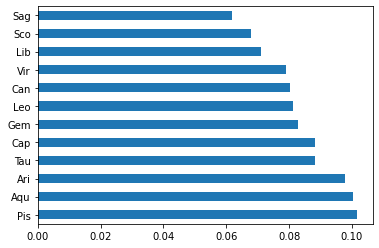

In [62]:
df['Zodiac'].value_counts(normalize=True).plot(kind = 'barh')

In this chart, we can see that the percentage of players who are Pis is the largest, while Sag is the smallest.

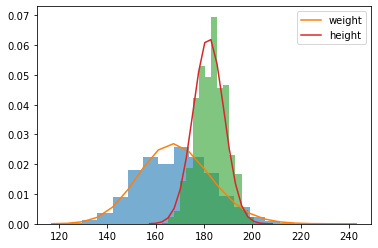

In [63]:
def pdfDistribution(arr): 
    _,bins,_ = plt.hist(arr, 20, density = True, alpha =0.6)
    a, loc, scale = stats.skewnorm.fit(arr)
    best_fit_line = stats.skewnorm.pdf(bins, a, loc, scale)    
    return plt.plot(bins, best_fit_line)

pdfDistribution(df['weight'])
pdfDistribution(df['height'])
plt.legend(['weight', 'height'])



In the chart above, the avg height of players is 183m and the average weight of players is 163 Lbs.

## Research question 3: Team Reference: Is there any statistically significant difference in the performance between home team and away team? 


In this section, we will use the metric: win rate of each team to evaluate the performance when the team be home team and away team. 
Methodology: 
- Create 1 column to define win match indicator for each team by match_id level
  - Win: 1
  - Draw or loose: 0
- Each column will be treated as iid random variables (identical and independent random variable) as the result of each team in each match is independent and identical, presented as array [0,1,..0,1] - received only 2 values 1: win, 0: not win
- Each array (home win rate or away win rate) will follow Binomial distribution. 
- According to Central Limit Theorem, regardless of what distribution of the population, the sampling distribution of the mean will follow Normal distribution. 
  - Use this theory to compare the mean of home team and away team. 
- Use t-test to test the difference between the 2 means is statistically significant difference. 

In [64]:
df = pd.read_sql("select * from match", conn)
df = df.iloc[:,:11]


In [65]:
df.head()

,id,country_id,league_id,season,stage,date,match_api_id,home_team_api_id,away_team_api_id,home_team_goal,away_team_goal
0,1,1,1,2008/2009,1,2008-08-17 00:00:00,492473,9987,9993,1,1
1,2,1,1,2008/2009,1,2008-08-16 00:00:00,492474,10000,9994,0,0
2,3,1,1,2008/2009,1,2008-08-16 00:00:00,492475,9984,8635,0,3
3,4,1,1,2008/2009,1,2008-08-17 00:00:00,492476,9991,9998,5,0
4,5,1,1,2008/2009,1,2008-08-16 00:00:00,492477,7947,9985,1,3


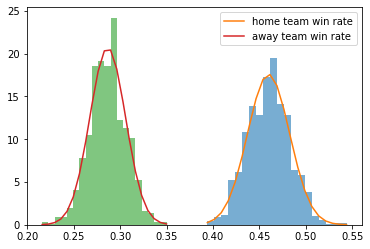

In [66]:
def winRate(arr1,arr2): 
    arr = arr1 > arr2
    arr = arr.apply(lambda x: 1 if x == True else 0)
    return arr
df['home team win rate'] = winRate(df['home_team_goal'], df['away_team_goal'])
df['away team win rate'] = winRate(df['away_team_goal'], df['home_team_goal'])

def Bootstraping(arr): 
    list_mean = []
    for _ in range(1000):
        mean = np.random.choice(arr, 500, replace = True).mean()
        list_mean.append(mean)    
    return np.array(list_mean)

home_team_win_rate = Bootstraping(df['home team win rate'])
away_team_win_rate = Bootstraping(df['away team win rate'])

def Normaldistribution(arr): 
    _,bins,_ = plt.hist(arr, 20, density = True, alpha = 0.6)
    mu, sigma = stats.norm.fit(arr)
    best_fit_line = stats.norm.pdf(bins, mu, sigma)
    return plt.plot(bins, best_fit_line)

Normaldistribution(home_team_win_rate)
Normaldistribution(away_team_win_rate)
plt.legend(['home team win rate', 'away team win rate'])


As the chart show that, while the mean of home team win rate is 0.46, the mean of away team win rate is 0.29. Home team win rate is remarkably larger than the away team win rate. 
To test this difference is statistically significant or not, we use t-test to test the difference between the 2 means. 
T_test theoretical analysis: 
- The t-test quantifies the difference between the arithmetic means of the two samples.
- The null hypothesis is that there is no statistically significant difference between the 2 means. 
- Whether or not reject the null hypothesis is based on p_value and the theshold alpha (0.05 or 0.1). If the p_value is greater than the threshold, the probability that we can observe the proof for the null hypothesis is significant that we can not reject the null hypothesis (H0).
- The statistic is calculated as (np.mean(a) - np.mean(b))/se, where se is the standard error.
  



In [67]:
stats.ttest_ind(home_team_win_rate, away_team_win_rate)

Ttest_indResult(statistic=183.9225738580674, pvalue=0.0)

For the test result, we have p_value is 0.0, which means that the probability is very small. Hence, the difference between the 2 means we observe is not by chance, the home team will perform better than the away team as they play in their home field.